<a href="https://colab.research.google.com/github/mitresthen/phys117_2021/blob/main/CNNSphaleronBlackhole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import seaborn as sns
from pathlib import Path

from PIL import Image


plt.ion()   # interactive mode

In [3]:
def pil_loader(path: str):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

def default_loader(path: str):
    from torchvision import get_image_backend

    if get_image_backend() == "accimage":
        return accimage_loader(path)
    else:
        return pil_loader(path)

def find_classes(directory: str, subdirs):
    """Finds the class folders in a dataset.
    See :class:`DatasetFolder` for details.
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if (entry.is_dir() and entry.name in subdirs) )
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")


class ImageFolderCustom(DatasetFolder):
    def __init__(
        self,
        root: str,
        subdirs,
        transform = None,
        target_transform = None,
        loader = default_loader,
        is_valid_file = None,
    ):
        self.subdirs = subdirs
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )
        self.imgs = self.samples

    def find_classes(self, directory):
      return find_classes(directory, self.subdirs)


In [4]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])



In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [6]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, device, dataset_sizes, num_epochs=25):
    print(f"training on {device} ")
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            iteration = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                iteration += 1
                if(iteration % 1000 == 0):
                  print(f"on iteration {iteration}")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, dataloaders, device, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


['BH_n6_M8', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
0:BH_n6_M8
1:PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL
2:ttbar
3:ttbar_largejets


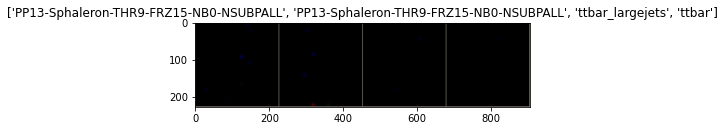

training on cuda:0 
Epoch 0/14
----------
on iteration 1000
on iteration 2000
on iteration 3000
on iteration 4000
on iteration 5000
on iteration 6000
on iteration 7000
on iteration 8000
train Loss: 0.6504 Acc: 0.7517
on iteration 1000
on iteration 2000
val Loss: 1.1761 Acc: 0.6527

Epoch 1/14
----------
on iteration 1000
on iteration 2000
on iteration 3000
on iteration 4000
on iteration 5000
on iteration 6000
on iteration 7000
on iteration 8000
train Loss: 0.4195 Acc: 0.8474
on iteration 1000
on iteration 2000
val Loss: 0.3558 Acc: 0.8743

Epoch 2/14
----------
on iteration 1000
on iteration 2000
on iteration 3000
on iteration 4000
on iteration 5000
on iteration 6000
on iteration 7000
on iteration 8000
train Loss: 0.3628 Acc: 0.8699
on iteration 1000
on iteration 2000
val Loss: 0.4015 Acc: 0.8498

Epoch 3/14
----------
on iteration 1000
on iteration 2000
on iteration 3000
on iteration 4000
on iteration 5000
on iteration 6000
on iteration 7000
on iteration 8000
train Loss: 0.3287 Acc: 0

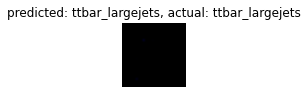

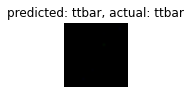

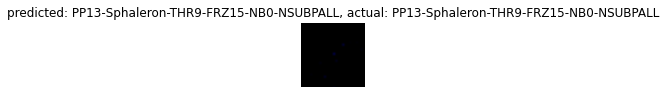

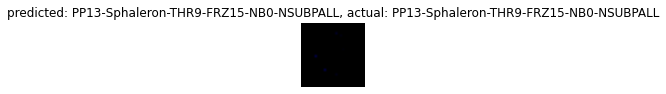

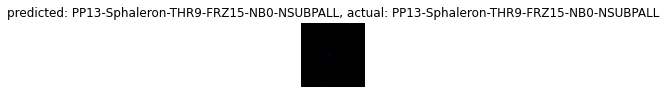

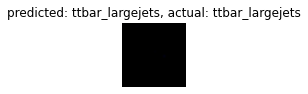

In [15]:
data_dir = 'generatedData'
bh_folders = sorted(entry.name for entry in os.scandir(data_dir) if (entry.is_dir() and entry.name.startswith("BH")) )

def makeModelWithBH(bh_folder):
  modelFileName = f"model_trained_{bh_folder}_new.pt"
  if (Path(modelFileName).is_file()):
    return
  subdirs = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "ttbar", "ttbar_largejets"]
  subdirs.append(bh_folder)
  image_dataset = ImageFolderCustom(data_dir, subdirs, transform=data_transform)

  train_size = int(0.8 * len(image_dataset))
  test_size = len(image_dataset) - train_size
  image_datasets = {}

  image_datasets["train"], image_datasets["val"] = torch.utils.data.random_split(image_dataset, [train_size, test_size])


#sampler=WeightedRandomSampler([0.9, 0.9, 0.1, 0.1], 4000, replacement=True)
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                               num_workers=4, shuffle=True)
                for x in ['train', 'val']}

  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  class_names = image_datasets['train'].dataset.classes
  print(class_names)
  for idx, name in enumerate(class_names):
    print(f"{idx}:{name}")

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  
  # Get a batch of training data
  inputs, classes = next(iter(dataloaders['train']))
  # Make a grid from batch
  out = torchvision.utils.make_grid(inputs)

  imshow(out, title=[class_names[x] for x in classes])

  model_ft = models.resnet18(pretrained=True)
  num_ftrs = model_ft.fc.in_features
  # Here the size of each output sample is set to 2.
  # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
  model_ft.fc = nn.Linear(num_ftrs, len(class_names))

  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders,
                         device, dataset_sizes, num_epochs=15)

  visualize_model(model_ft, dataloaders, device, class_names)

  torch.save(model_ft.state_dict(), modelFileName)



makeModelWithBH("BH_n6_M8")
#for folders in bh_folders:
#  makeModelWithBH(folders)


['BH_n5_M10', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n5_M10.pt: Got 7195 / 8027 with accuracy 89.63


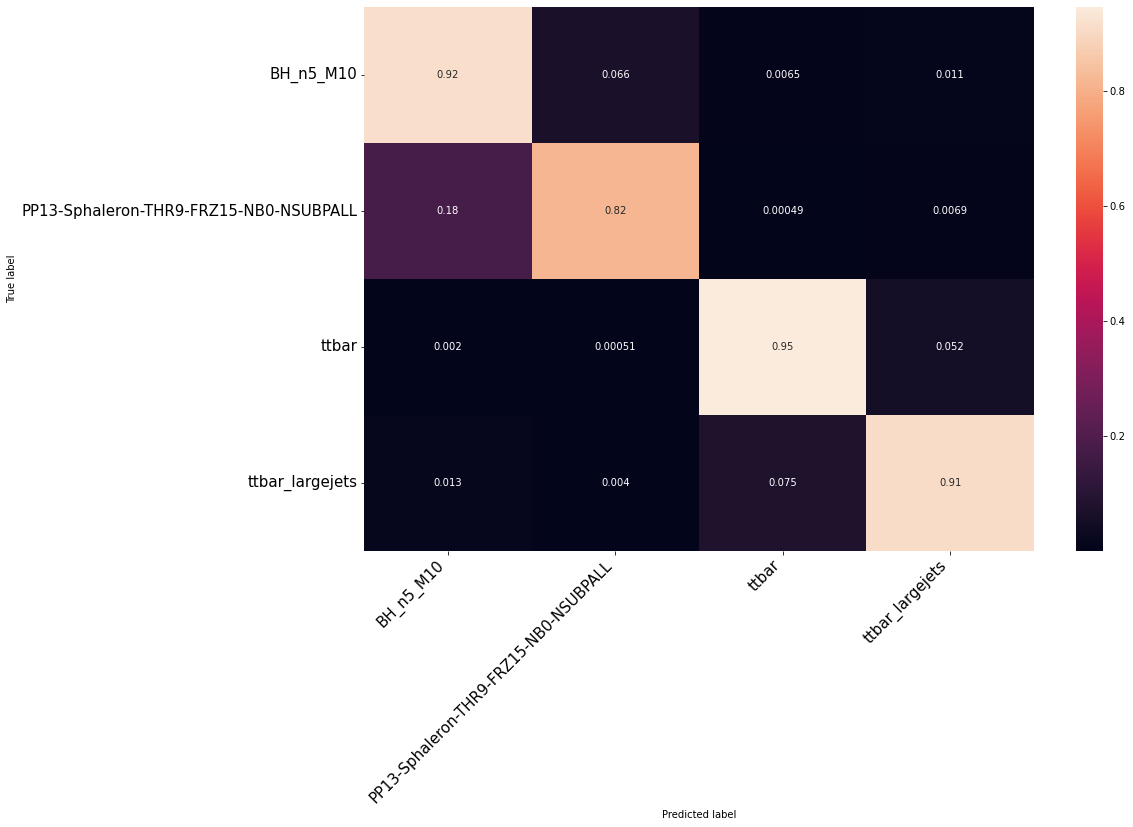

In [9]:
from torchvision.models import ResNet
data_dir = 'generatedData'

def loadAndPlot(folder):
  subdirs = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "ttbar", "ttbar_largejets"]
  subdirs.append(folder)
  image_dataset = ImageFolderCustom(data_dir, subdirs, transform=data_transform)

  train_size = int(0.8 * len(image_dataset))
  test_size = len(image_dataset) - train_size
  image_datasets = {}

  image_datasets["train"], image_datasets["val"] = torch.utils.data.random_split(image_dataset, [train_size, test_size])


  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                               num_workers=4, shuffle=True)
                for x in ['train', 'val']}

  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  class_names = image_datasets['train'].dataset.classes
  print(class_names)


  model_path = f"model_trained_{folder}.pt"
  if (not Path(model_path).is_file()):
    return
  model_ft = models.resnet18(pretrained=True)
  model_ft.fc = nn.Linear(model_ft.fc.in_features, len(class_names))

  model_ft.load_state_dict(torch.load(model_path))
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model_ft = model_ft.to(device)

  model_ft.eval()

  nb_classes = len(class_names)

  num_correct = 0
  num_samples = 0

  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(dataloaders['val']):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model_ft(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
            num_samples += 1
            num_correct += (t == p)


  plt.figure(figsize=(15,10))
  print(f'for {model_path}: Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 

  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
  normalized_df = df_cm.div(df_cm.sum(axis=1), axis=0)
  heatmap = sns.heatmap(normalized_df, annot=True)

  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

bh_folders = sorted(entry.name for entry in os.scandir(data_dir) if (entry.is_dir() and entry.name.startswith("BH")) )

loadAndPlot("BH_n5_M10")
#for folder in bh_folders:
#  loadAndPlot(folder)



['BH_n6_M8', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
['BH_n4_M10', 'BH_n4_M11', 'BH_n4_M12', 'BH_n4_M8', 'BH_n4_M9', 'BH_n5_M10', 'BH_n5_M11', 'BH_n5_M12', 'BH_n5_M8', 'BH_n5_M9', 'BH_n6_M10', 'BH_n6_M11', 'BH_n6_M12', 'BH_n6_M8', 'BH_n6_M9', 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'ttbar', 'ttbar_largejets']
for model_trained_BH_n6_M8_new.pt: Got 9064 / 35758 with accuracy 25.35%


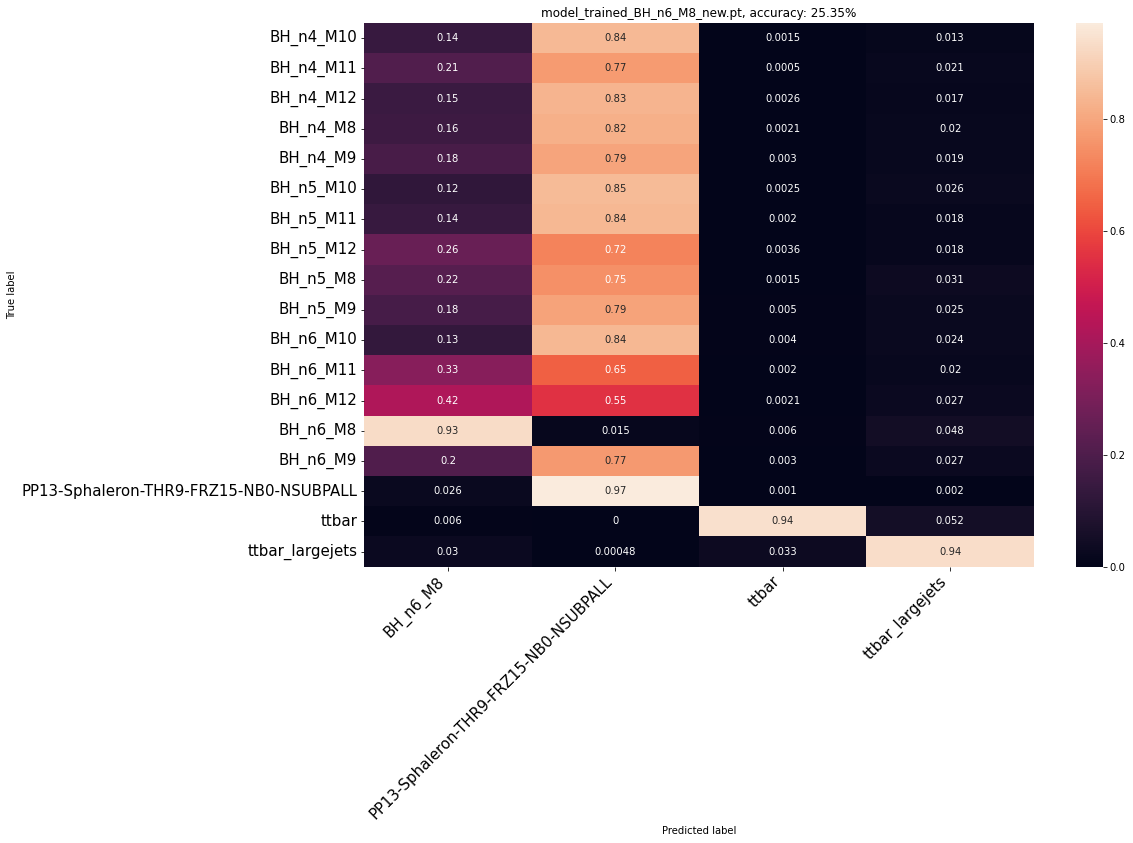

In [20]:
from torchvision.models import ResNet
data_dir = 'generatedData'

def loadAndPlotAll(folder):
  subdirs = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "ttbar", "ttbar_largejets"]
  bh_folders = sorted(entry.name for entry in os.scandir(data_dir) if (entry.is_dir() and entry.name.startswith("BH")) )
  for subfolder in bh_folders:
    subdirs.append(subfolder)

  image_dataset = ImageFolderCustom(data_dir, subdirs, transform=data_transform)

  train_size = int(0.8 * len(image_dataset))
  test_size = len(image_dataset) - train_size
  image_datasets = {}

  image_datasets["train"], image_datasets["val"] = torch.utils.data.random_split(image_dataset, [train_size, test_size])


  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                               num_workers=4, shuffle=True)
                for x in ['train', 'val']}

  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  class_names =  [folder, "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "ttbar", "ttbar_largejets"] #image_datasets['train'].dataset.classes
  print(class_names)

  real_class_names = image_datasets['train'].dataset.classes
  print(real_class_names)
  real_nb_classes = len(real_class_names)


  model_path = f"model_trained_{folder}_new.pt"
  if (not Path(model_path).is_file()):
    return
  model_ft = models.resnet18(pretrained=True)
  model_ft.fc = nn.Linear(model_ft.fc.in_features, len(class_names))

  model_ft.load_state_dict(torch.load(model_path))
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model_ft = model_ft.to(device)

  model_ft.eval()

  nb_classes = len(class_names)

  num_correct = 0
  num_samples = 0

  confusion_matrix = torch.zeros(real_nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(dataloaders['val']):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model_ft(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
            num_samples += 1
            if class_names[p].startswith("BH") and real_class_names[t].startswith("BH"):
              num_correct += 1
            else:
              num_correct += (t == p)


  plt.figure(figsize=(15,10))
  accuracy = f"{float(num_correct)/float(num_samples)*100:.2f}"
  print(f'for {model_path}: Got {num_correct} / {num_samples} with accuracy {accuracy}%') 

  df_cm = pd.DataFrame(confusion_matrix, index=real_class_names, columns=class_names).astype(int)
  normalized_df = df_cm.div(df_cm.sum(axis=1), axis=0)
  heatmap = sns.heatmap(normalized_df, annot=True)

  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title(f"{model_path}, accuracy: {accuracy}%")
  plt.show()

bh_folders = sorted(entry.name for entry in os.scandir(data_dir) if (entry.is_dir() and entry.name.startswith("BH")) )

#for folder in bh_folders:
#  loadAndPlotAll(folder)
loadAndPlotAll("BH_n6_M8")



In [11]:
import random

def reduceFilesRandomly(fromdir, appxNrFilesToKeep):
  toDir = f"{fromdir}_others"
  keepRate = appxNrFilesToKeep/len(os.listdir(fromdir))

  for image in os.listdir(fromdir):
    fromName = f"{fromdir}/{image}"
    toName = f"{toDir}/{image}"
    if(random.random() > keepRate):
      os.rename(fromName, toName)

#reduceFilesRandomly("ttbar", 10000)
#reduceFilesRandomly("ttbar_largejets", 10000)